In [1]:
import sctoolbox
from sctoolbox.utilities import bgcolor

/home/jdetlef/.conda/envs/sctoolbox/lib/python3.10/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==59.5.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


# Batch effect correction and comparisons
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [2]:
%bgcolor PowderBlue

# Choose normalization method
norm_methods = ['tfidf', 'total']  # can be 'tfidf' and/or 'total'

# Set number of neighbors
n_neighbors = 15  #Default=15

# UMAP related settings 
metacol = 'sample'

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_column = "sample"
perform_batch_correction = True
batch_methods = ["bbknn", "harmony"] # "mnn", "scanorama"
threads = 8

<hr style="border:2px solid black"> </hr>

## Set up

In [3]:
import sctoolbox.tools as tools
import sctoolbox.plotting as pl
import sctoolbox.utils as utils
import scanpy as sc
import episcanpy as epi
import numpy as np
import matplotlib.pyplot as plt
utils.settings_from_config("config.yaml", key="03")

sc.set_figure_params(vector_friendly=True, dpi_save=600, scanpy=False)

[WARNING] Log file '../logs/03_log.txt' already exists. The file will be overwritten since 'overwrite_log' is set to True.


----------------

## Load anndata 

In [4]:
# probably updated in future
adata = utils.load_h5ad("anndata_2.h5ad")
display(adata)

[INFO] The adata object was loaded from: ../adatas/anndata_2.h5ad


AnnData object with n_obs × n_vars = 2384 × 4514
    obs: 'sample', 'fld_score', 'total_counts', 'log1p_total_counts', 'doublet_score', 'predicted_doublet', 'n_features', 'log1p_n_features'
    var: 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: 'sctoolbox'
    layers: 'raw'

----------

## Normalization

In [5]:
normalizations = tools.normalize_adata(adata, norm_methods)

[INFO] Performing TFIDF and LSI...
[INFO] Performing total normalization and PCA...


--------

## Show PC embedding per method

In [6]:
%bgcolor PowderBlue

# number of PCs shown within the heatmap
n_pcs_heatmap = 15

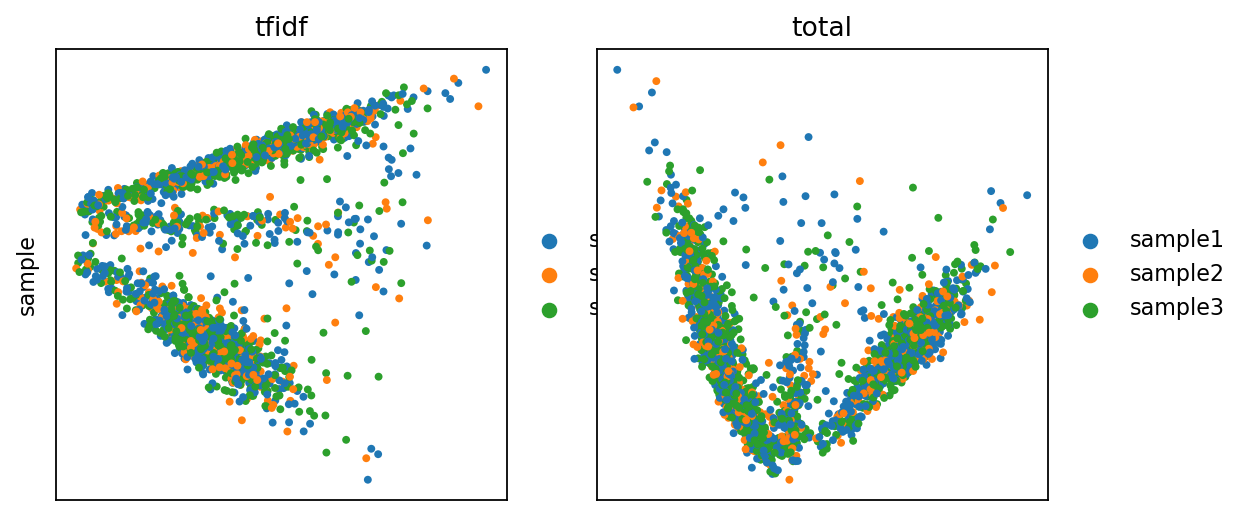

In [7]:
_ = pl.compare_embeddings(list(normalizations.values()), adata_names=list(normalizations.keys()),
                          var_list=[batch_column], embedding="pca")

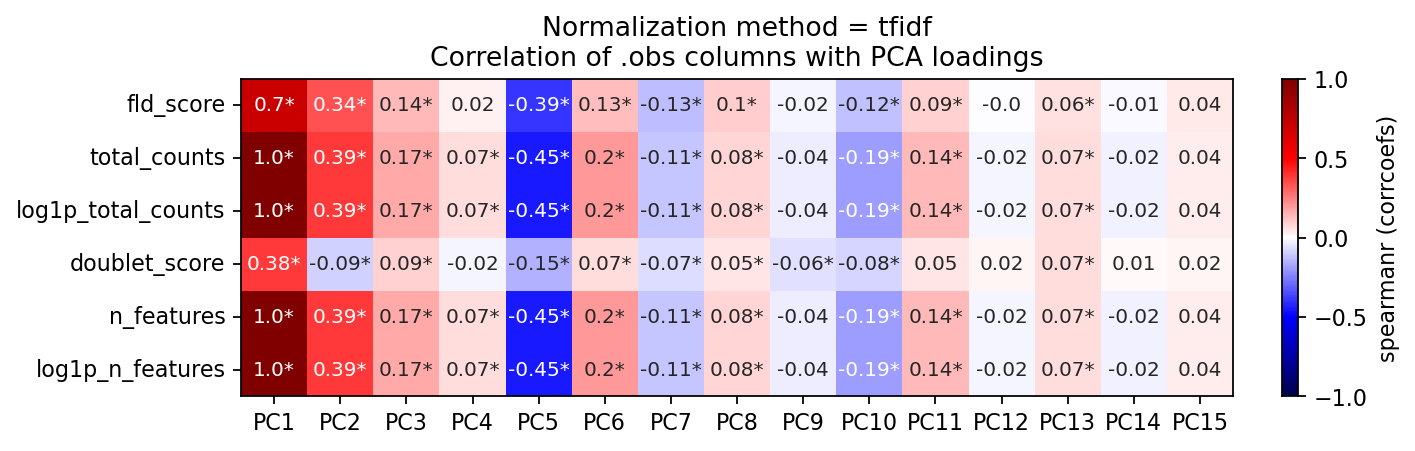

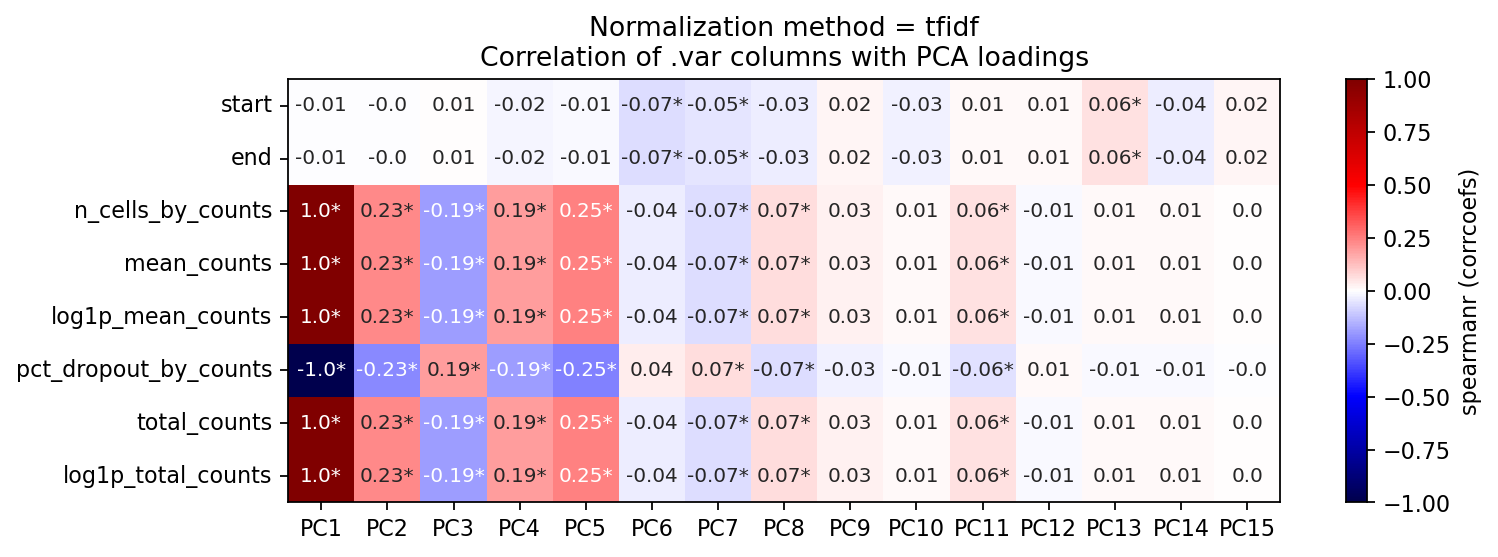

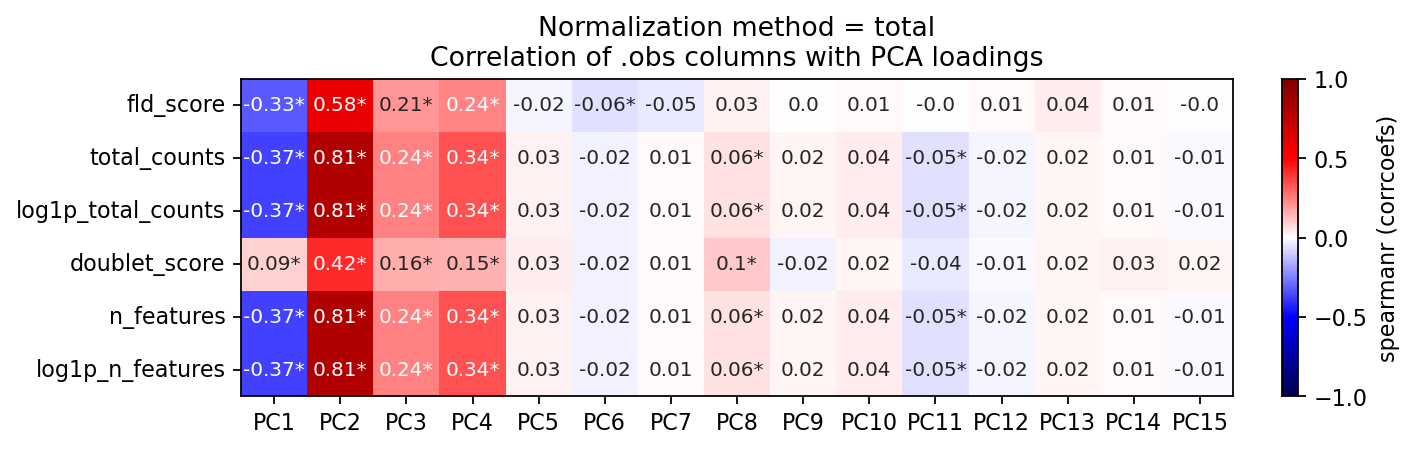

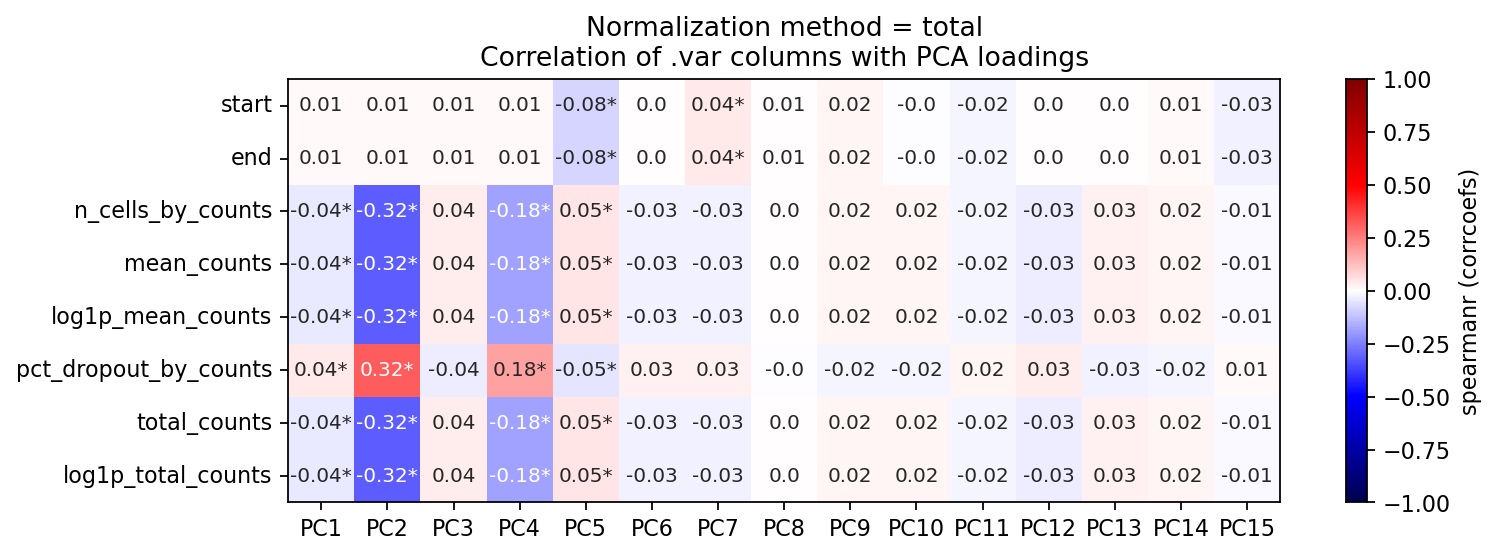

In [8]:
# PCA correlations with obs and var variables
for method, adata_norm in normalizations.items():
    
    _ = pl.plot_pca_correlation(adata_norm, 
                                n_components=n_pcs_heatmap,
                                which="obs", 
                                title=f"Normalization method = {method}\nCorrelation of .obs columns with PCA loadings",
                                save=f"PCA_{method}_correlation_obs.pdf")
    
    _ = pl.plot_pca_correlation(adata_norm, 
                                n_components=n_pcs_heatmap,
                                which="var", 
                                title=f"Normalization method = {method}\nCorrelation of .var columns with PCA loadings",
                                save=f"PCA_{method}_correlation_var.pdf")

---------------------

## Subset PCs

In [9]:
%bgcolor PowderBlue

# Whether PCs should be filtered
subset_pcs = True

corr_thresh = 0.5  # PCs with an absolut correlation above this will be filtered
perc_thresh = 50  # Top percentile of PCs that should be kept
filter_methods = ['variance', 'correlation']  # propose PCs based on the provided methods
basis = 'obs'  # base correlation on obs or var

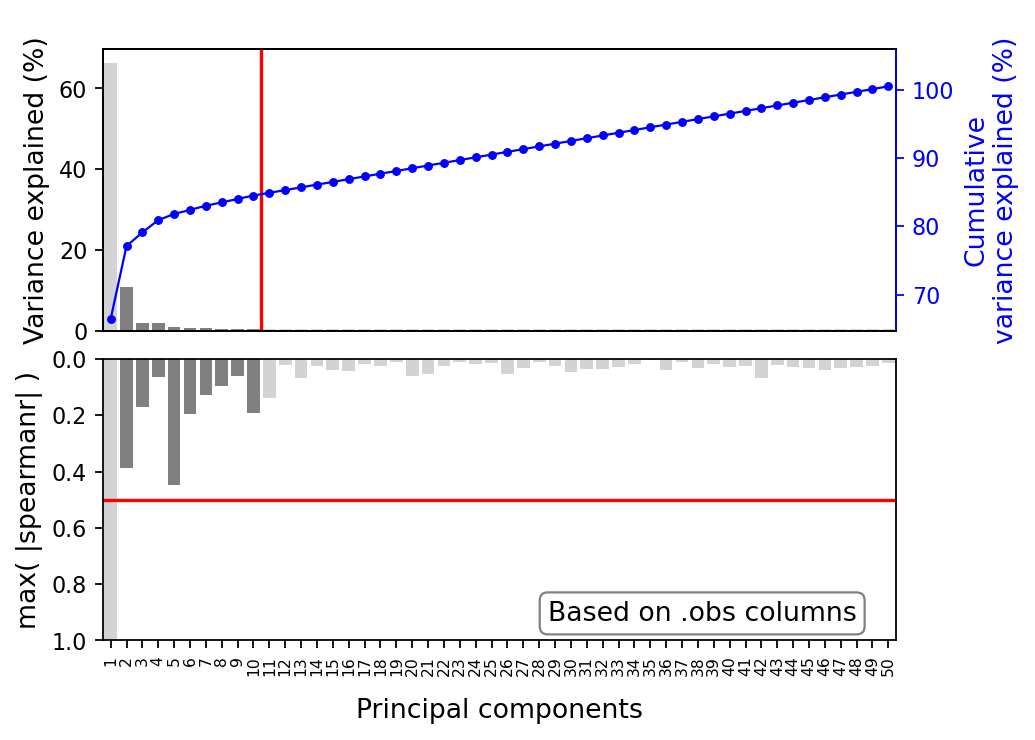

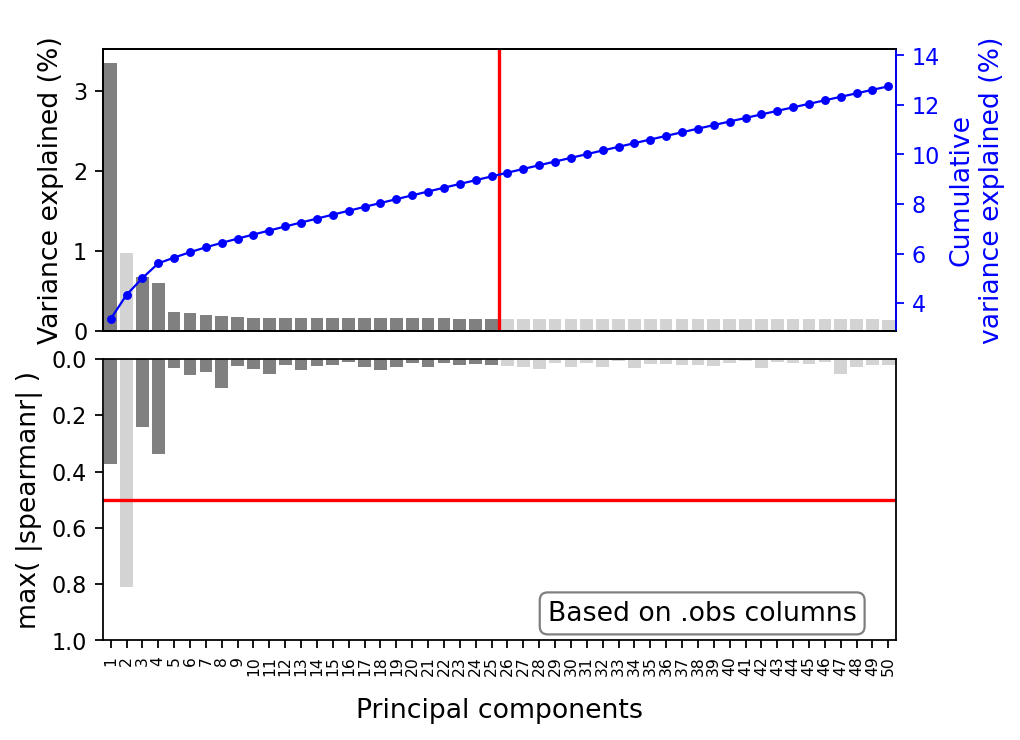

In [10]:
if subset_pcs:
    for key, adata_normed in normalizations.items():
        
        selected_pcs = tools.propose_pcs(anndata=adata_normed,
                                 how=filter_methods,
                                 corr_thresh=corr_thresh,
                                 perc_thresh=perc_thresh,
                                 corr_kwargs={'method': 'spearmanr', 'which': basis})
        
        # Plot and select number of PCs
        _, ax = plt.subplots()
        ax.set_title(key)
        _ = pl.plot_pca_variance(adata_normed, 
                                 save=key + "_PCA_variance_selected.pdf",selected=selected_pcs,
                                 n_pcs=50,
                                 n_thresh=max(selected_pcs),
                                 corr_plot='spearmanr',
                                 corr_thresh=corr_thresh,
                                 corr_on=basis, 
                                 ax=ax)
        tools.subset_PCA(adata_normed, select=selected_pcs)
        
        normalizations[key] = adata_normed

--------

## Calc standard neighbors and umap for each adata

In [11]:
for adata in normalizations.values():
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, method='umap', metric='euclidean')

In [12]:
tools.wrap_umap(normalizations.values())

Computing UMAPs :   0%|          | 0/2 [00:00<?, ?it/s]

------------------------

## Compare between normalizations

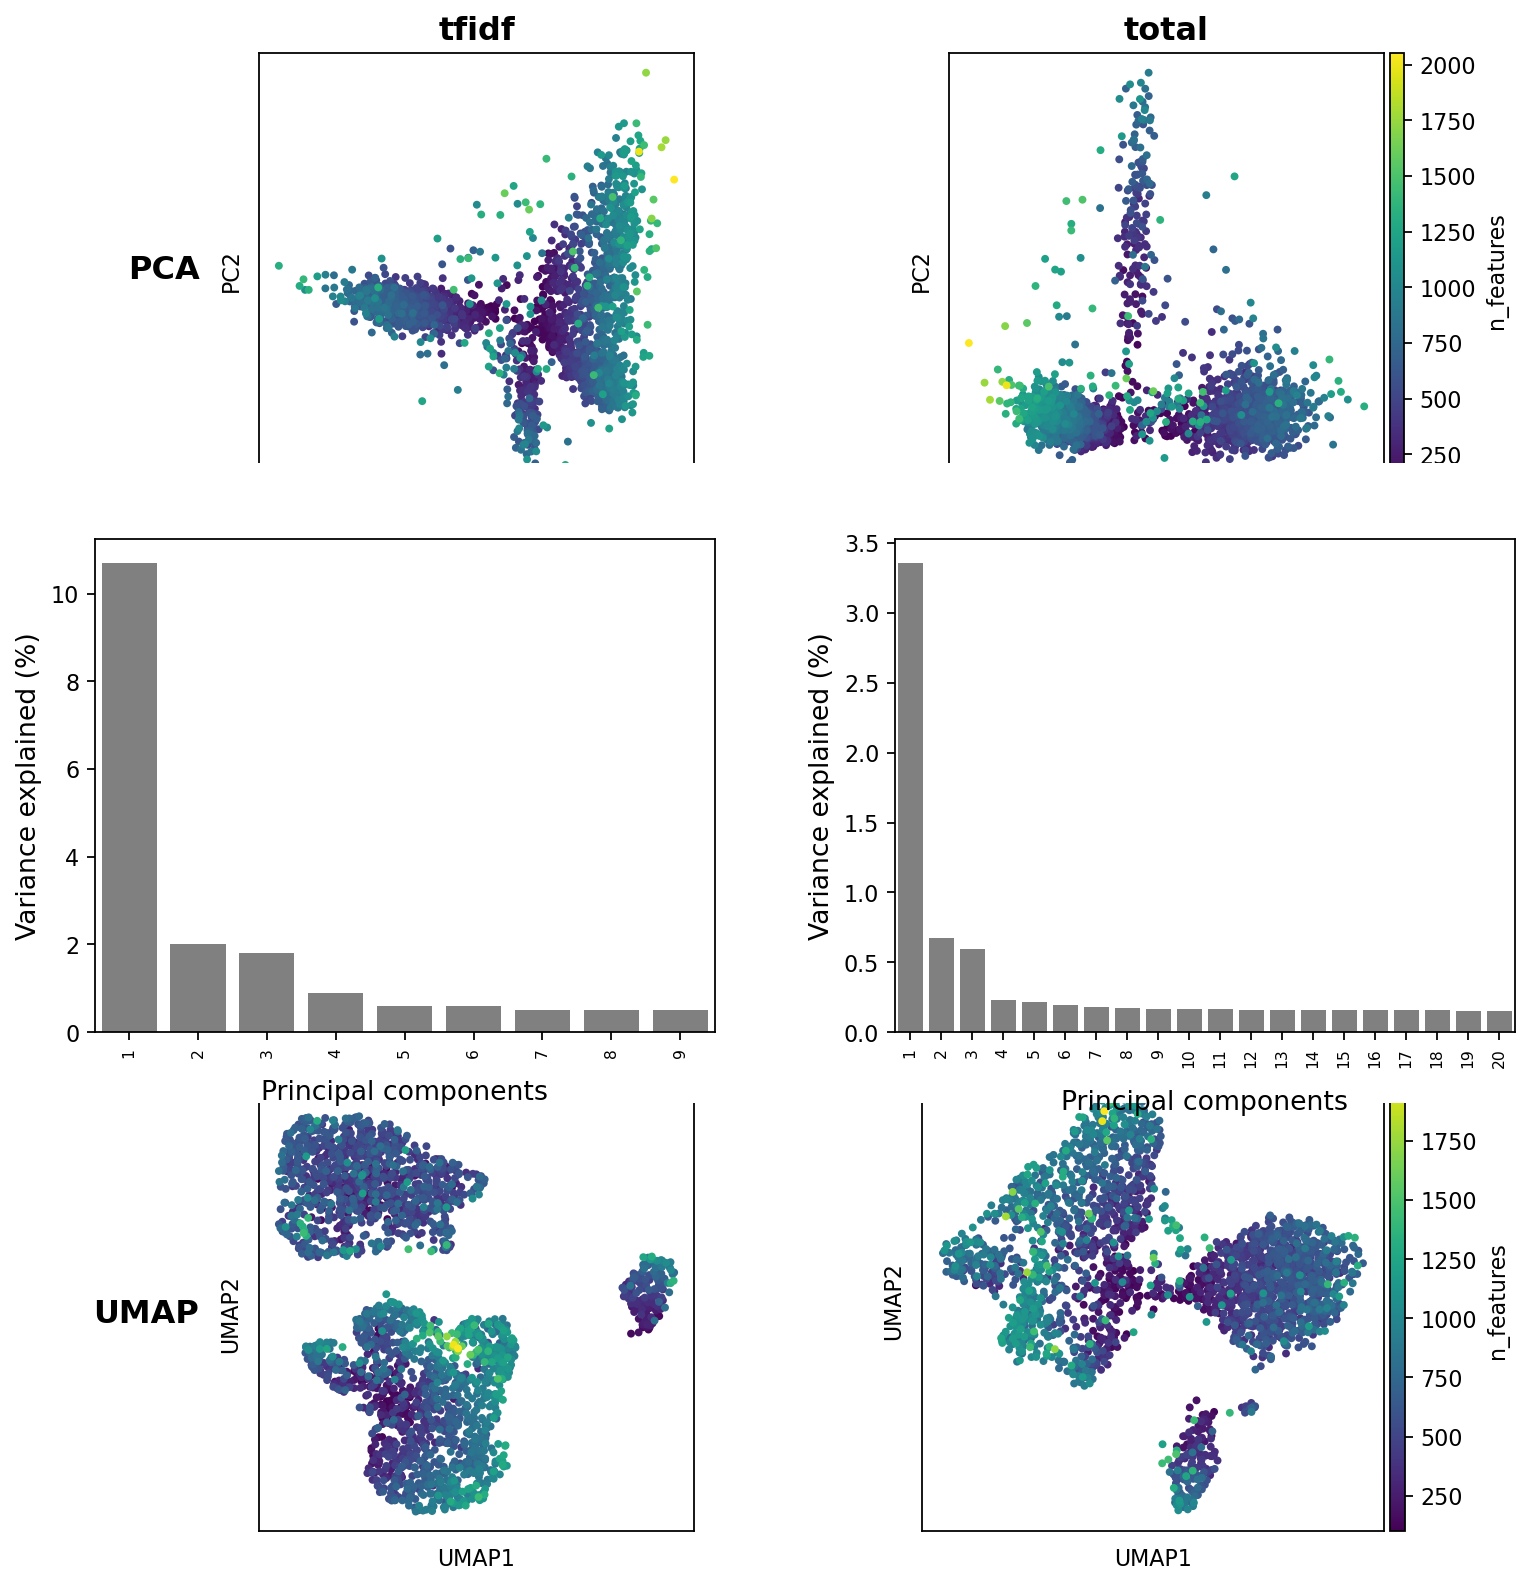

In [13]:
#Plot the overview of batch correction methods
_ = pl.anndata_overview(normalizations, 
                        plots=["PCA", "PCA-var", "UMAP"],
                        color_by=["n_features"], 
                        output=None)

In [14]:
%bgcolor PowderBlue

# Choose the final normalization method
norm_method = "tfidf"

adata = normalizations[norm_method]

-----------

## Plot final PCA

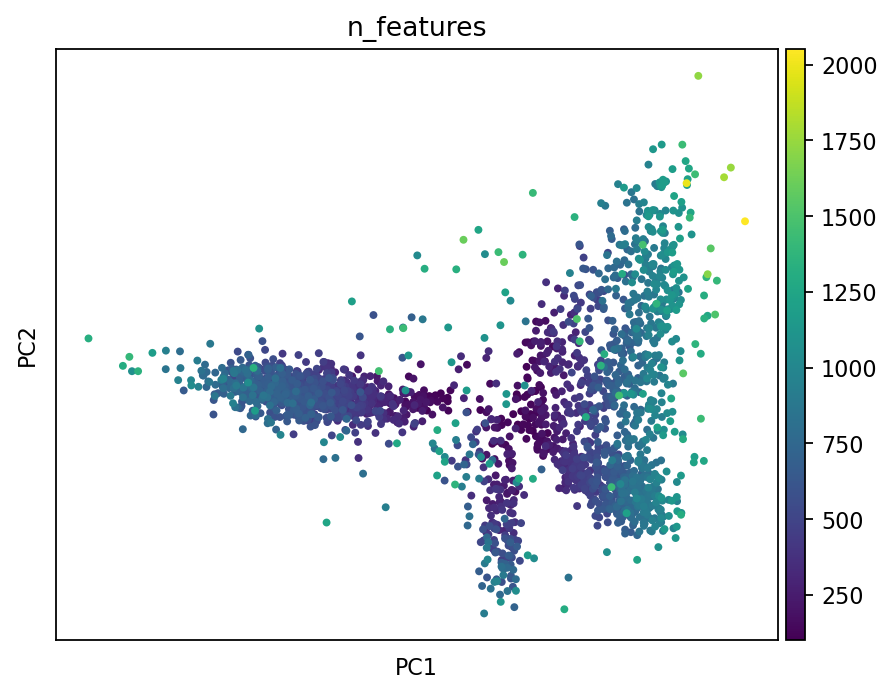

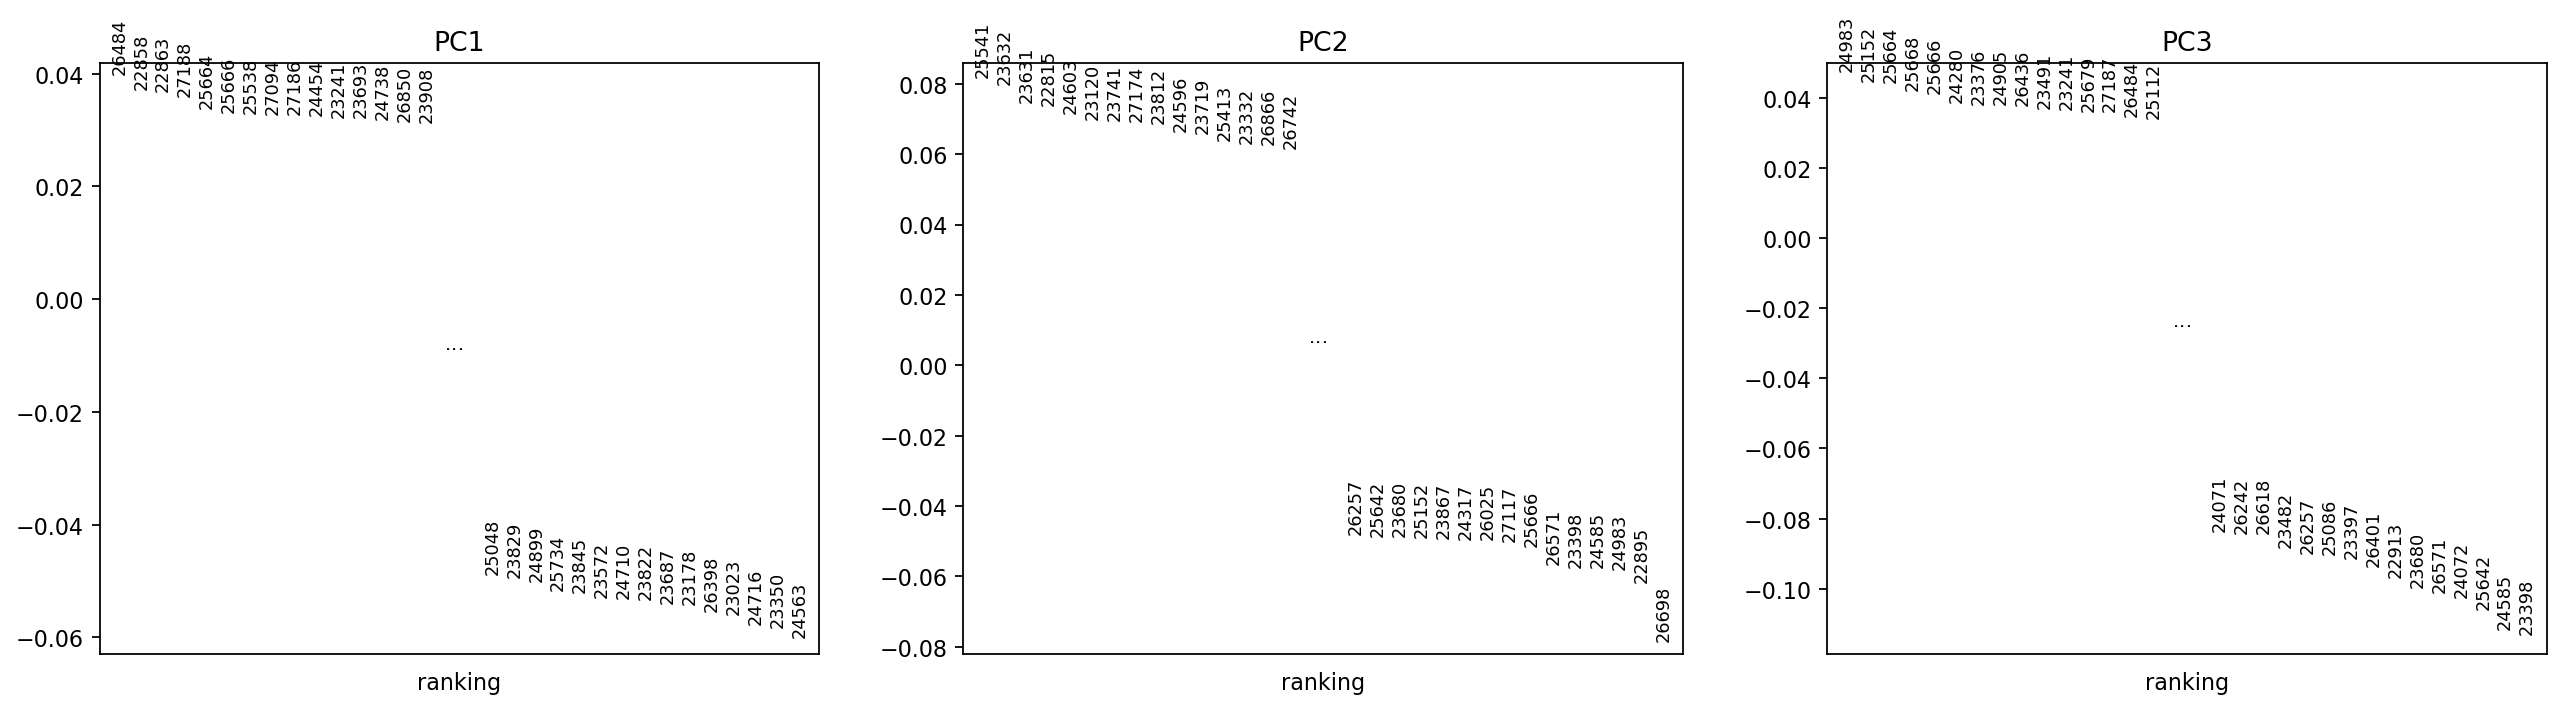

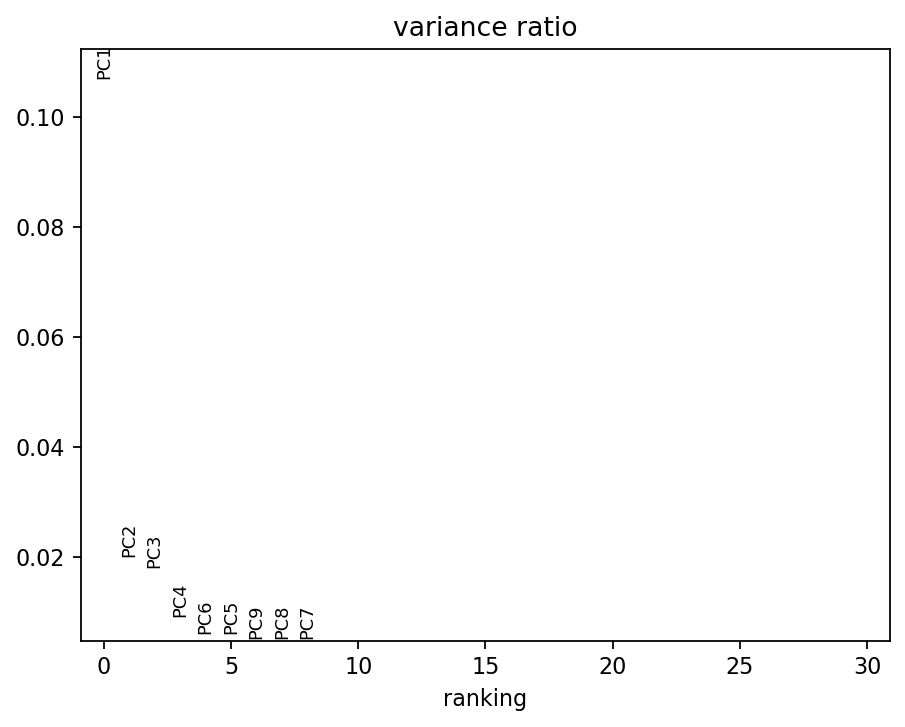

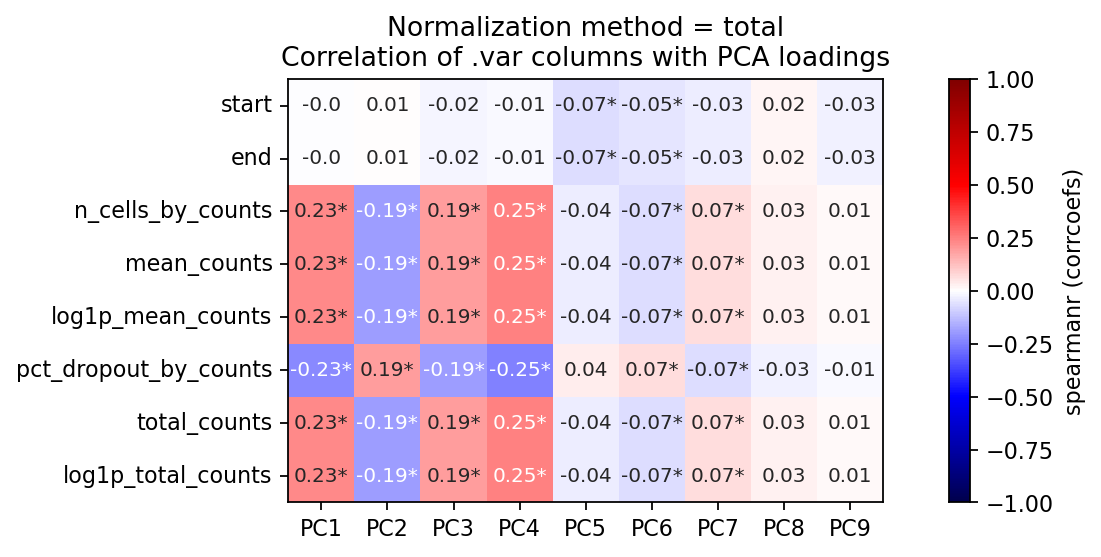

In [15]:
sc.pl.pca_overview(adata, color=['n_features'], show=False)

_ = pl.plot_pca_correlation(adata, which="var", 
                            title=f"Normalization method = {method}\nCorrelation of .var columns with PCA loadings",
                            save=f"PCA_{method}_correlation_var.pdf")

-----------

## Batch correction

In [16]:
if perform_batch_correction:
    batch_corrections = tools.wrap_corrections(adata, 
                                                  batch_key=batch_column,
                                                  methods=batch_methods)
else:
    batch_corrections = {"uncorrected": adata}

[INFO] Running batch correction with 'bbknn'...
[INFO] Running batch correction with 'harmony'...
[INFO] Finished batch correction(s)!


In [17]:
#Run standard umap for all adatas
tools.wrap_umap(batch_corrections.values(), threads=threads)

Computing UMAPs :   0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
# Should preliminary clustering be performed?
do_clustering = True #True or False

In [19]:
#Perform additional clustering if it was chosen
color_by = []
if do_clustering:
    for adata in batch_corrections.values():
        sc.tl.leiden(adata, 0.1)
    color_by.append("leiden")

In [20]:
# Calculate LISI scores for batch
tools.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

Calculating LISI scores:   0%|          | 0/6 [00:00<?, ?it/s]

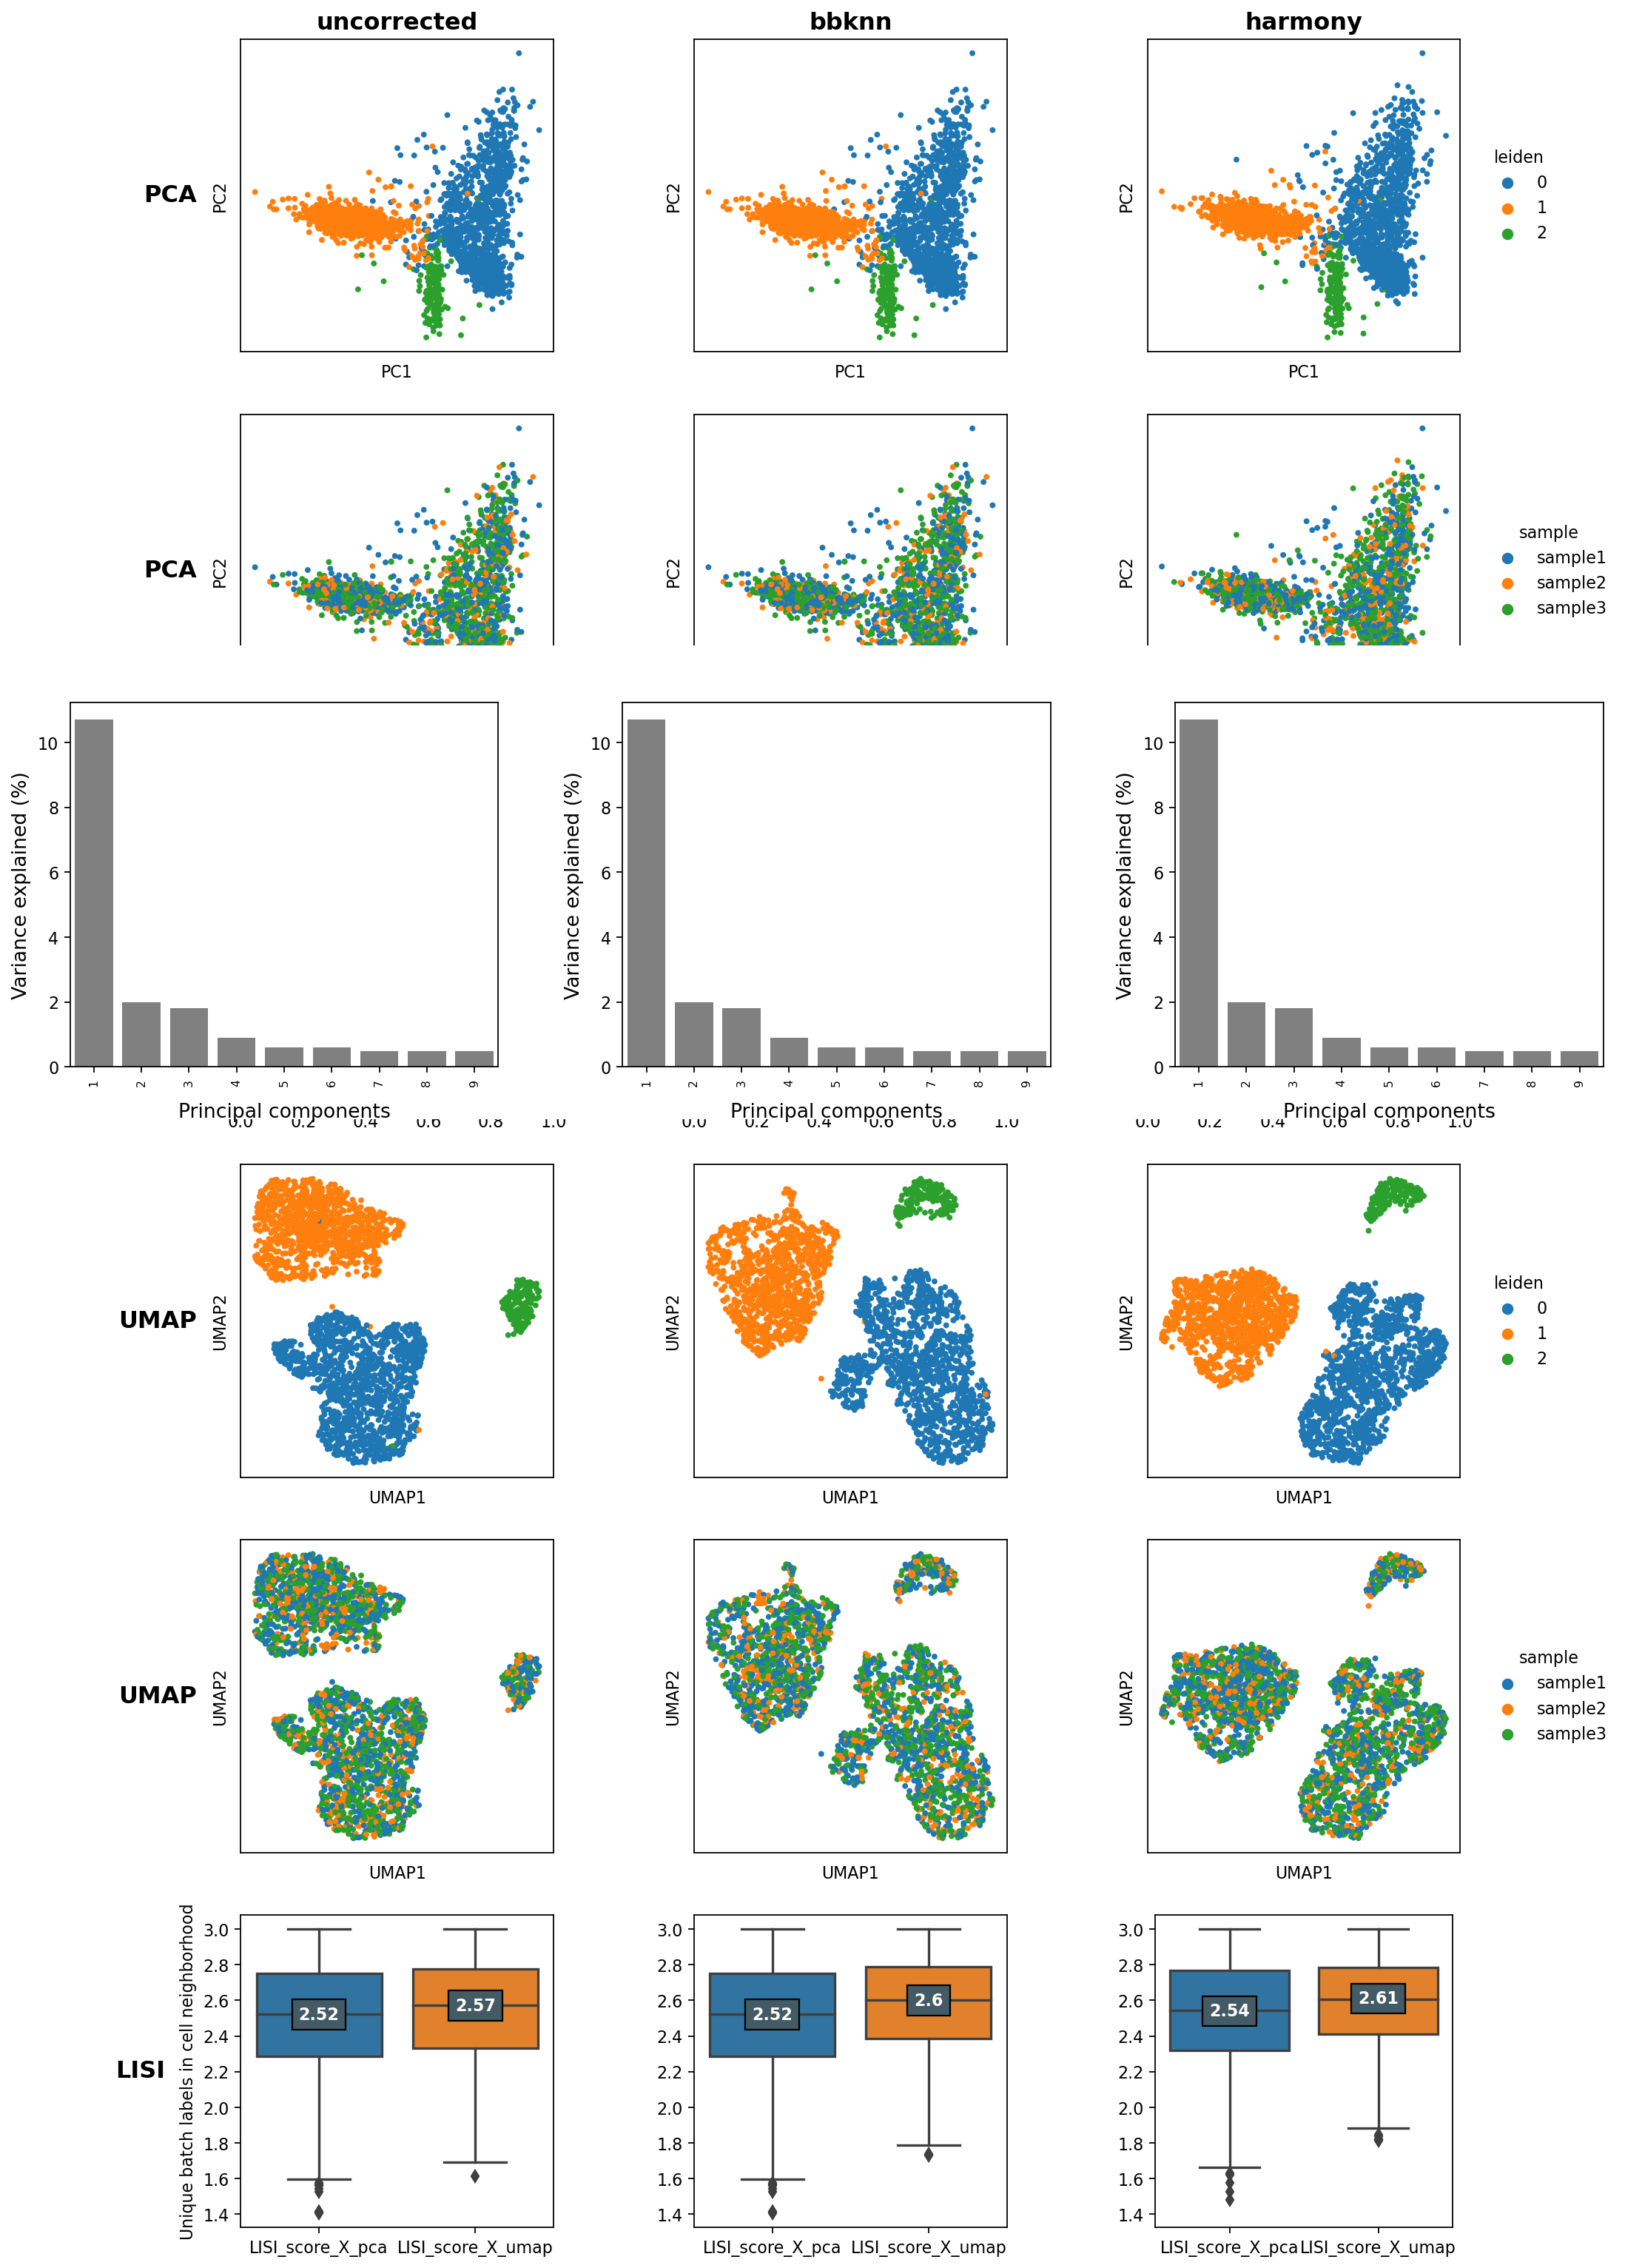

In [21]:
#Plot the overview of batch correction methods
adata.obs[batch_column] = adata.obs[batch_column].astype("category") #ensure that batch column is a category

_ = pl.anndata_overview(batch_corrections, color_by=color_by + [batch_column], 
                        output=None)

In [22]:
%bgcolor PowderBlue

#Choose an anndata object to proceed
batch_name = "bbknn"

adata_corrected = batch_corrections[batch_name]

---------

## Save anndata

In [23]:
#Saving the data
adata_output = "anndata_3.h5ad"
utils.save_h5ad(adata, adata_output)

[INFO] The adata object was saved to: ../adatas/anndata_3.h5ad
